# Predicting DTC occurence using ODB-II dataset

## Data pre-processing

In [1]:
import numpy as np
import pandas as pd
from tsfresh.utilities.dataframe_functions import roll_time_series
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

%matplotlib inline

In [43]:
data_path = '../data/odb-2-master-thesis/exp1_14drivers_14cars_dailyRoutes_formatted.csv' 

df = pd.read_csv(data_path)
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit='ms')

df.head()

/tmp/ipykernel_6167/1774789070.py:3: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


,TIMESTAMP,MARK,MODEL,CAR_YEAR,ENGINE_POWER,AUTOMATIC,VEHICLE_ID,BAROMETRIC_PRESSURE(KPA),ENGINE_COOLANT_TEMP,FUEL_LEVEL,...,THROTTLE_POS,DTC_NUMBER,TROUBLE_CODES,TIMING_ADVANCE,EQUIV_RATIO,MIN,HOURS,DAYS_OF_WEEK,MONTHS,YEAR
0,2017-08-16 16:55:04.267,chevrolet,agile,2011.0,1.4,n,car1,100.0,80.0,0.486,...,0.251,MIL is OFF0 codes,NaN,0.569,0.01,13.0,16.0,2.0,8.0,2017.0
1,2017-08-16 16:55:12.283,chevrolet,agile,2011.0,1.4,n,car1,100.0,80.0,0.486,...,0.251,MIL is OFF0 codes,NaN,0.565,0.01,13.0,16.0,2.0,8.0,2017.0
2,2017-08-16 16:55:20.291,chevrolet,agile,2011.0,1.4,n,car1,100.0,80.0,0.486,...,0.251,MIL is OFF0 codes,NaN,0.573,0.01,13.0,16.0,2.0,8.0,2017.0
3,2017-08-16 16:55:28.300,chevrolet,agile,2011.0,1.4,n,car1,100.0,80.0,0.486,...,0.251,MIL is OFF0 codes,NaN,0.565,0.01,13.0,16.0,2.0,8.0,2017.0
4,2017-08-16 16:55:36.320,chevrolet,agile,2011.0,1.4,n,car1,100.0,80.0,0.486,...,0.251,MIL is OFF0 codes,NaN,0.569,0.01,13.0,16.0,2.0,8.0,2017.0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47514 entries, 0 to 47513
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   TIMESTAMP                    47514 non-null  datetime64[ns]
 1   MARK                         47459 non-null  object        
 2   MODEL                        47459 non-null  object        
 3   CAR_YEAR                     47459 non-null  float64       
 4   ENGINE_POWER                 47459 non-null  float64       
 5   AUTOMATIC                    47459 non-null  object        
 6   VEHICLE_ID                   47514 non-null  object        
 7   BAROMETRIC_PRESSURE(KPA)     10212 non-null  float64       
 8   ENGINE_COOLANT_TEMP          33964 non-null  float64       
 9   FUEL_LEVEL                   2994 non-null   float64       
 10  ENGINE_LOAD                  30972 non-null  float64       
 11  AMBIENT_AIR_TEMP             3619 non-nul

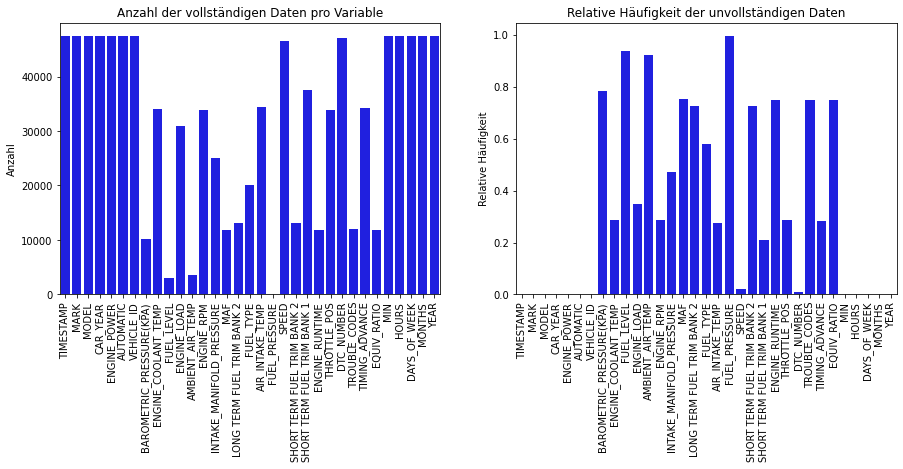

In [61]:
def plot_missing_counts(dataset):
    # Leere Subplots (Barplots) erstellen
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    features = dataset.count().index
    values = dataset.count().values
    
    # Das Barplot 1.a konfigurieren
    ax1.set_title("Anzahl der vollständigen Daten pro Variable")
    ax1.set_ylabel("Anzahl")
    ax1.set_xticklabels(features, rotation=90)
    sns.barplot(features, values, ax=ax1, color="blue")

    # Das Barplot 1.b konfigurieren
    values = (len(dataset.index) - dataset.count().values) / len(dataset.index)
    ax2.set_title("Relative Häufigkeit der unvollständigen Daten")
    ax2.set_ylabel("Relative Häufigkeit")
    ax2.set_xticklabels(features, rotation=90)
    sns.barplot(features, values, ax=ax2, color="blue")

    plt.show()
    
plot_missing_counts(df)

In [96]:
cols = ["BAROMETRIC_PRESSURE(KPA)", "FUEL_LEVEL", "AMBIENT_AIR_TEMP", "MAF", "LONG TERM FUEL TRIM BANK 2", 
        "INTAKE_MANIFOLD_PRESSURE", "FUEL_TYPE", "FUEL_PRESSURE", "SHORT TERM FUEL TRIM BANK 2", 
        "ENGINE_RUNTIME", "EQUIV_RATIO", "MARK", "MODEL", "CAR_YEAR", "ENGINE_POWER", "AUTOMATIC", 
        "FUEL_TYPE", "DTC_NUMBER", "DAYS_OF_WEEK", "HOURS", "MIN", "MONTHS", "YEAR"]

selected_columns = df.columns.difference(cols)

print(selected_columns)

Index(['AIR_INTAKE_TEMP', 'ENGINE_COOLANT_TEMP', 'ENGINE_LOAD', 'ENGINE_RPM',
       'SHORT TERM FUEL TRIM BANK 1', 'SPEED', 'THROTTLE_POS', 'TIMESTAMP',
       'TIMING_ADVANCE', 'TROUBLE_CODES', 'VEHICLE_ID'],
      dtype='object')


In [98]:
df[selected_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47514 entries, 0 to 47513
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   AIR_INTAKE_TEMP              34352 non-null  float64       
 1   ENGINE_COOLANT_TEMP          33964 non-null  float64       
 2   ENGINE_LOAD                  30972 non-null  float64       
 3   ENGINE_RPM                   33859 non-null  float64       
 4   SHORT TERM FUEL TRIM BANK 1  37595 non-null  float64       
 5   SPEED                        46529 non-null  float64       
 6   THROTTLE_POS                 33859 non-null  float64       
 7   TIMESTAMP                    47514 non-null  datetime64[ns]
 8   TIMING_ADVANCE               34162 non-null  float64       
 9   TROUBLE_CODES                11925 non-null  object        
 10  VEHICLE_ID                   47514 non-null  object        
dtypes: datetime64[ns](1), float64(8), object(

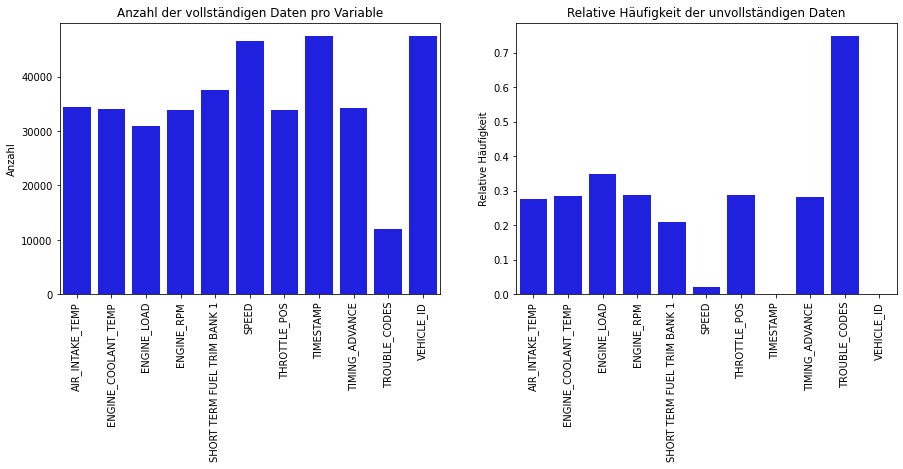

In [103]:
plot_missing_counts(df[selected_columns])

In [100]:
selected_columns.difference(["TROUBLE_CODES"])

Index(['AIR_INTAKE_TEMP', 'ENGINE_COOLANT_TEMP', 'ENGINE_LOAD', 'ENGINE_RPM',
       'SHORT TERM FUEL TRIM BANK 1', 'SPEED', 'THROTTLE_POS', 'TIMESTAMP',
       'TIMING_ADVANCE', 'VEHICLE_ID'],
      dtype='object')

In [91]:
df["VEHICLE_ID"].unique()

array(['car1', 'car7', 'car3', 'car4', 'car5', 'car6', 'car8', 'car11',
       'car2', 'car9', 'car10', 'car12', 'car13', 'car14'], dtype=object)

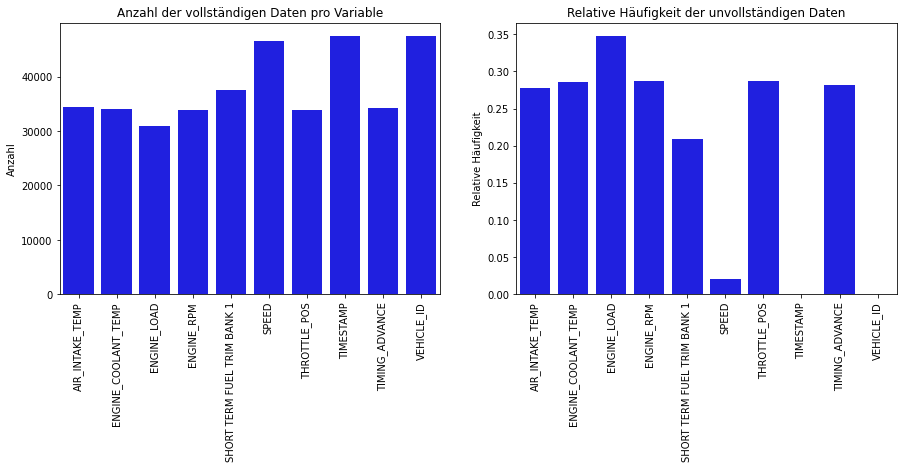

In [102]:
plot_missing_counts(
    df[selected_columns.difference(["TROUBLE_CODES", "VEHICLE_ID"])]
)

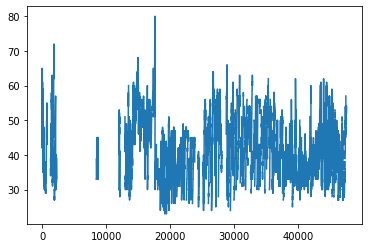

In [66]:
plt.plot(df["AIR_INTAKE_TEMP"])
plt.show()

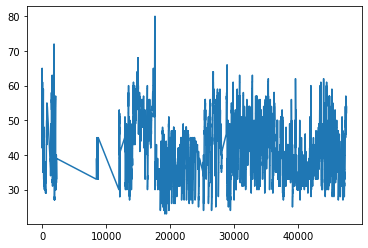

In [83]:
plt.plot(df[col_name].interpolate(method="linear").values)
plt.show()

In [ ]:
df2 = df[col_name].interpolate(method="spline")

plt.plot(df2.values)
plt.show()

In [107]:
df[selected_columns.difference(["TROUBLE_CODES", "VEHICLE_ID"])].describe()

,AIR_INTAKE_TEMP,ENGINE_COOLANT_TEMP,ENGINE_LOAD,ENGINE_RPM,SHORT TERM FUEL TRIM BANK 1,SPEED,THROTTLE_POS,TIMING_ADVANCE
count,34352.000000,33964.000000,30972.000000,33859.000000,37595.000000,46529.000000,33859.000000,34162.000000
mean,41.243101,81.772023,0.404915,1517.803391,-0.349164,24.743751,0.179412,0.549504
std,8.517170,10.910737,0.214347,613.937502,0.538568,29.294017,0.088885,0.177077
min,23.000000,22.000000,0.051000,438.000000,-1.000000,0.000000,0.008000,0.004000
25%,35.000000,78.000000,0.255000,906.000000,-1.000000,0.000000,0.125000,0.498000
50%,40.000000,85.000000,0.388000,1487.000000,-0.039000,14.000000,0.176000,0.584000
75%,47.000000,88.000000,0.494000,1957.000000,0.008000,42.000000,0.231000,0.675000
max,80.000000,105.000000,1.000000,3816.000000,0.992000,143.000000,0.871000,0.878000


In [121]:
df_interpolated = pd.DataFrame()

for col in selected_columns.difference(["TROUBLE_CODES", "VEHICLE_ID", "TIMESTAMP"]):
    print(col)
    df_interpolated[col] = df[col].interpolate(method="linear")

AIR_INTAKE_TEMP
ENGINE_COOLANT_TEMP
ENGINE_LOAD
ENGINE_RPM
SHORT TERM FUEL TRIM BANK 1
SPEED
THROTTLE_POS
TIMING_ADVANCE


In [123]:
df_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47514 entries, 0 to 47513
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   AIR_INTAKE_TEMP              47514 non-null  float64
 1   ENGINE_COOLANT_TEMP          47514 non-null  float64
 2   ENGINE_LOAD                  47514 non-null  float64
 3   ENGINE_RPM                   47514 non-null  float64
 4   SHORT TERM FUEL TRIM BANK 1  46692 non-null  float64
 5   SPEED                        47514 non-null  float64
 6   THROTTLE_POS                 47514 non-null  float64
 7   TIMING_ADVANCE               47514 non-null  float64
dtypes: float64(8)
memory usage: 2.9 MB


In [133]:
df_interpolated["SHORT TERM FUEL TRIM BANK 1"] = df_interpolated["SHORT TERM FUEL TRIM BANK 1"].fillna(0)

In [137]:
df_interpolated[["TROUBLE_CODES", "VEHICLE_ID", "TIMESTAMP"]] = df[["TROUBLE_CODES", "VEHICLE_ID", "TIMESTAMP"]]

In [138]:
df_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47514 entries, 0 to 47513
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   AIR_INTAKE_TEMP              47514 non-null  float64       
 1   ENGINE_COOLANT_TEMP          47514 non-null  float64       
 2   ENGINE_LOAD                  47514 non-null  float64       
 3   ENGINE_RPM                   47514 non-null  float64       
 4   SHORT TERM FUEL TRIM BANK 1  47514 non-null  float64       
 5   SPEED                        47514 non-null  float64       
 6   THROTTLE_POS                 47514 non-null  float64       
 7   TIMING_ADVANCE               47514 non-null  float64       
 8   TROUBLE_CODES                11925 non-null  object        
 9   VEHICLE_ID                   47514 non-null  object        
 10  TIMESTAMP                    47514 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(

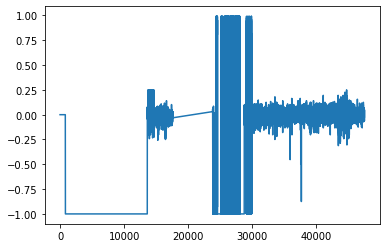

In [134]:
plt.plot(df_interpolated["SHORT TERM FUEL TRIM BANK 1"].index, 
         df_interpolated["SHORT TERM FUEL TRIM BANK 1"].values)

plt.show()

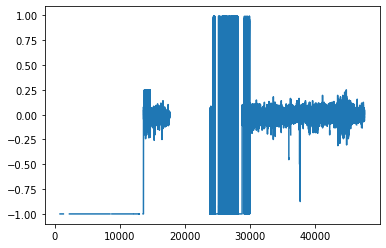

In [140]:
plt.plot(df["SHORT TERM FUEL TRIM BANK 1"].index, 
         df["SHORT TERM FUEL TRIM BANK 1"].values)

plt.show()

In [141]:
df["VEHICLE_ID"].unique()

array(['car1', 'car7', 'car3', 'car4', 'car5', 'car6', 'car8', 'car11',
       'car2', 'car9', 'car10', 'car12', 'car13', 'car14'], dtype=object)

In [183]:
for car_id in df_interpolated["VEHICLE_ID"].unique():
    print("VEHICLE_ID:", car_id)
    trouble_codes = df_interpolated[df_interpolated["VEHICLE_ID"] == car_id]["TROUBLE_CODES"]
    print("Num rows:", len(trouble_codes))
    print("TROUBLE_CODES unique values:", trouble_codes.unique())
    print("TROUBLE_CODES:\n", trouble_codes.value_counts())
    print("")
    
    

VEHICLE_ID: car1
Num rows: 13617
TROUBLE_CODES unique values: [nan]
TROUBLE_CODES:
 Series([], Name: TROUBLE_CODES, dtype: int64)

VEHICLE_ID: car7
Num rows: 507
TROUBLE_CODES unique values: [nan]
TROUBLE_CODES:
 Series([], Name: TROUBLE_CODES, dtype: int64)

VEHICLE_ID: car3
Num rows: 903
TROUBLE_CODES unique values: [nan]
TROUBLE_CODES:
 Series([], Name: TROUBLE_CODES, dtype: int64)

VEHICLE_ID: car4
Num rows: 2920
TROUBLE_CODES unique values: [nan]
TROUBLE_CODES:
 Series([], Name: TROUBLE_CODES, dtype: int64)

VEHICLE_ID: car5
Num rows: 55
TROUBLE_CODES unique values: [nan]
TROUBLE_CODES:
 Series([], Name: TROUBLE_CODES, dtype: int64)

VEHICLE_ID: car6
Num rows: 6184
TROUBLE_CODES unique values: ['P0133' nan]
TROUBLE_CODES:
 P0133    6070
Name: TROUBLE_CODES, dtype: int64

VEHICLE_ID: car8
Num rows: 5574
TROUBLE_CODES unique values: [nan]
TROUBLE_CODES:
 Series([], Name: TROUBLE_CODES, dtype: int64)

VEHICLE_ID: car11
Num rows: 7485
TROUBLE_CODES unique values: [nan]
TROUBLE_CODES:


In [ ]:
df_interpolated["TROUBLE_CODES_BINARY"] = (df_interpolated["TROUBLE_CODES"].notnull() * 1)

In [177]:
df_interpolated.info()

ERROR! Session/line number was not unique in database. History logging moved to new session 70
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47514 entries, 0 to 47513
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   AIR_INTAKE_TEMP              47514 non-null  float64       
 1   ENGINE_COOLANT_TEMP          47514 non-null  float64       
 2   ENGINE_LOAD                  47514 non-null  float64       
 3   ENGINE_RPM                   47514 non-null  float64       
 4   SHORT TERM FUEL TRIM BANK 1  47514 non-null  float64       
 5   SPEED                        47514 non-null  float64       
 6   THROTTLE_POS                 47514 non-null  float64       
 7   TIMING_ADVANCE               47514 non-null  float64       
 8   TROUBLE_CODES                11925 non-null  object        
 9   VEHICLE_ID                   47514 non-null  object        
 10  TIMESTAMP  

In [ ]:
%%time

df3 = df_interpolated[df_interpolated.columns.difference(["TROUBLE_CODES"])].head(1000)

window_size = 89

df_rolling = roll_time_series(df3, 
                              column_id="VEHICLE_ID", 
                              column_sort="TIMESTAMP", 
                              max_timeshift=window_size, 
                              min_timeshift=window_size, 
                              n_jobs=1)
df_rolling.head()

In [200]:
df_interpolated.to_csv('../data/odb-2-master-thesis/exp1_14drivers_14cars_dailyRoutes_interpolated.csv', index=False)

## Create sliding windows

In [2]:
df = pd.read_csv("../data/odb-2-master-thesis/exp1_14drivers_14cars_dailyRoutes_interpolated.csv")
df.head()

,AIR_INTAKE_TEMP,ENGINE_COOLANT_TEMP,ENGINE_LOAD,ENGINE_RPM,SHORT TERM FUEL TRIM BANK 1,SPEED,THROTTLE_POS,TIMING_ADVANCE,TROUBLE_CODES,VEHICLE_ID,TIMESTAMP,TROUBLE_CODES_BINARY
0,59.0,80.0,0.333,1009.0,0.0,0.0,0.251,0.569,NaN,car1,2017-08-16 16:55:04.267,0
1,59.0,80.0,0.325,1003.0,0.0,0.0,0.251,0.565,NaN,car1,2017-08-16 16:55:12.283,0
2,59.0,80.0,0.329,995.0,0.0,0.0,0.251,0.573,NaN,car1,2017-08-16 16:55:20.291,0
3,60.0,80.0,0.325,1004.0,0.0,0.0,0.251,0.565,NaN,car1,2017-08-16 16:55:28.300,0
4,60.0,80.0,0.329,1005.0,0.0,0.0,0.251,0.569,NaN,car1,2017-08-16 16:55:36.320,0


In [37]:
selected_columns = df.columns.difference(["TROUBLE_CODES"])
df_car1 = df[selected_columns]
df_car1 = df_car1[df_car1["VEHICLE_ID"] == "car1"]
window_size = 89

df_car1_windows = roll_time_series(df_car1, 
                                    column_id="VEHICLE_ID", 
                                    column_sort="TIMESTAMP", 
                                    max_timeshift=(window_size - 1), 
                                    min_timeshift=(window_size - 1), 
                                    n_jobs=8)
df_car1_windows.head()

Rolling: 100%|████████████████████████████████████████████████████████████████| 40/40 [00:17<00:00,  2.25it/s]


,AIR_INTAKE_TEMP,ENGINE_COOLANT_TEMP,ENGINE_LOAD,ENGINE_RPM,SHORT TERM FUEL TRIM BANK 1,SPEED,THROTTLE_POS,TIMESTAMP,TIMING_ADVANCE,TROUBLE_CODES_BINARY,VEHICLE_ID,id
0,59.0,80.0,0.333,1009.0,0.0,0.0,0.251,2017-08-16 16:55:04.267,0.569,0,car1,"(car1, 2017-08-16 20:08:32.130)"
1,59.0,80.0,0.325,1003.0,0.0,0.0,0.251,2017-08-16 16:55:12.283,0.565,0,car1,"(car1, 2017-08-16 20:08:32.130)"
2,59.0,80.0,0.329,995.0,0.0,0.0,0.251,2017-08-16 16:55:20.291,0.573,0,car1,"(car1, 2017-08-16 20:08:32.130)"
3,60.0,80.0,0.325,1004.0,0.0,0.0,0.251,2017-08-16 16:55:28.300,0.565,0,car1,"(car1, 2017-08-16 20:08:32.130)"
4,60.0,80.0,0.329,1005.0,0.0,0.0,0.251,2017-08-16 16:55:36.320,0.569,0,car1,"(car1, 2017-08-16 20:08:32.130)"


In [36]:
len(df_car1_windows)

1204081

In [58]:
grouped_target = df_car1_windows.groupby("id")["TROUBLE_CODES_BINARY"].tail(1)

display(grouped_target)
display(grouped_target.values)

88         0
177        0
266        0
355        0
444        0
          ..
1203724    0
1203813    0
1203902    0
1203991    0
1204080    0
Name: TROUBLE_CODES_BINARY, Length: 13529, dtype: int64

array([0, 0, 0, ..., 0, 0, 0])

In [82]:
pd.DataFrame(grouped_target.values)

,0
0,0
1,0
2,0
3,0
4,0
...,...
13524,0
13525,0
13526,0
13527,0


In [55]:
len(len(grouped_target) * list(range(0, window_size))) == len(df_car1_windows)

True

In [62]:
# Add a new timepoints column
df_car1_windows["TIMEPOINTS"] = pd.Series(len(grouped_target) * list(range(0, window_size)))
df_car1_windows.columns

Index(['AIR_INTAKE_TEMP', 'ENGINE_COOLANT_TEMP', 'ENGINE_LOAD', 'ENGINE_RPM',
       'SHORT TERM FUEL TRIM BANK 1', 'SPEED', 'THROTTLE_POS', 'TIMESTAMP',
       'TIMING_ADVANCE', 'TROUBLE_CODES_BINARY', 'VEHICLE_ID', 'id',
       'TIMEPOINTS'],
      dtype='object')

In [63]:
# Drop unnecessary columns 
df_car1_windows = df_car1_windows.drop(["TIMESTAMP", "TROUBLE_CODES_BINARY", "VEHICLE_ID", "id"], axis=1)
df_car1_windows.columns

Index(['AIR_INTAKE_TEMP', 'ENGINE_COOLANT_TEMP', 'ENGINE_LOAD', 'ENGINE_RPM',
       'SHORT TERM FUEL TRIM BANK 1', 'SPEED', 'THROTTLE_POS',
       'TIMING_ADVANCE', 'TIMEPOINTS'],
      dtype='object')

In [72]:
df_car1_windows["INSTANCES"] = pd.Series(
    np.array(([[x]*len(grouped_target) for x in range(0, window_size)])).flatten()
)
df_car1_windows.columns

Index(['AIR_INTAKE_TEMP', 'ENGINE_COOLANT_TEMP', 'ENGINE_LOAD', 'ENGINE_RPM',
       'SHORT TERM FUEL TRIM BANK 1', 'SPEED', 'THROTTLE_POS',
       'TIMING_ADVANCE', 'TIMEPOINTS', 'INSTANCES'],
      dtype='object')

In [73]:
# Adjust columns order
df_car1_windows = df_car1_windows[['INSTANCES', 'TIMEPOINTS', 'AIR_INTAKE_TEMP', 'ENGINE_COOLANT_TEMP', 
                                   'ENGINE_LOAD', 'ENGINE_RPM', 'SHORT TERM FUEL TRIM BANK 1', 
                                   'SPEED', 'THROTTLE_POS', 'TIMING_ADVANCE']]
df_car1_windows.columns

Index(['INSTANCES', 'TIMEPOINTS', 'AIR_INTAKE_TEMP', 'ENGINE_COOLANT_TEMP',
       'ENGINE_LOAD', 'ENGINE_RPM', 'SHORT TERM FUEL TRIM BANK 1', 'SPEED',
       'THROTTLE_POS', 'TIMING_ADVANCE'],
      dtype='object')

In [74]:
df_car1_windows.head()

,INSTANCES,TIMEPOINTS,AIR_INTAKE_TEMP,ENGINE_COOLANT_TEMP,ENGINE_LOAD,ENGINE_RPM,SHORT TERM FUEL TRIM BANK 1,SPEED,THROTTLE_POS,TIMING_ADVANCE
0,0,0,59.0,80.0,0.333,1009.0,0.0,0.0,0.251,0.569
1,0,1,59.0,80.0,0.325,1003.0,0.0,0.0,0.251,0.565
2,0,2,59.0,80.0,0.329,995.0,0.0,0.0,0.251,0.573
3,0,3,60.0,80.0,0.325,1004.0,0.0,0.0,0.251,0.565
4,0,4,60.0,80.0,0.329,1005.0,0.0,0.0,0.251,0.569


In [79]:
df_car1_windows = df_car1_windows.rename(columns={"AIR_INTAKE_TEMP": "AIR INTAKE TEMP", 
                                                  "ENGINE_COOLANT_TEMP": "ENGINE COOLANT TEMP", 
                                                  "ENGINE_LOAD": "ENGINE LOAD", 
                                                  "ENGINE_RPM": "ENGINE RPM", 
                                                  "THROTTLE_POS": "THROTTLE POS", 
                                                  "TIMING_ADVANCE": "TIMING ADVANCE"})
df_car1_windows.columns

Index(['INSTANCES', 'TIMEPOINTS', 'AIR INTAKE TEMP', 'ENGINE COOLANT TEMP',
       'ENGINE LOAD', 'ENGINE RPM', 'SHORT TERM FUEL TRIM BANK 1', 'SPEED',
       'THROTTLE POS', 'TIMING ADVANCE'],
      dtype='object')

## Save the features and target variables into csv files

In [80]:
# Save the dataframe to csv file
car_id = "car1"
data_path = f'../data/odb-2-master-thesis/features-{car_id}-windowsize{window_size}.csv'
df_car1_windows.to_csv(data_path, index=False)

In [84]:
data_path = f'../data/odb-2-master-thesis/target-binary-{car_id}-windowsize{window_size}.csv'
pd.DataFrame(grouped_target.values).to_csv(data_path, index=False)

## Read the multiindex csv file

In [81]:
# Read multiindex csv
df_car1_windows = pd.read_csv(data_path, index_col=[0,1])
df_car1_windows.head()

AIR INTAKE TEMP  ENGINE COOLANT TEMP  ENGINE LOAD  \
INSTANCES TIMEPOINTS                                                      
0         0                      59.0                 80.0        0.333   
          1                      59.0                 80.0        0.325   
          2                      59.0                 80.0        0.329   
          3                      60.0                 80.0        0.325   
          4                      60.0                 80.0        0.329   

                      ENGINE RPM  SHORT TERM FUEL TRIM BANK 1  SPEED  \
INSTANCES TIMEPOINTS                                                   
0         0               1009.0                          0.0    0.0   
          1               1003.0                          0.0    0.0   
          2                995.0                          0.0    0.0   
          3               1004.0                          0.0    0.0   
          4               1005.0                          0.0    0.0   

                      THROTTLE POS  TIMING ADVANCE  
INSTANCES TIMEPOINTS                                
0         0                  0.251           0.569  
          1                  0.251           0.565  
          2                  0.251           0.573  
          3                  0.251           0.565  
          4                  0.251           0.569

## Data processing for all car ID

In [11]:
car_ids = df["VEHICLE_ID"].unique()
car_ids = pd.Index(car_ids)
car_ids = car_ids.difference(["car5", "car2", "car10", "car14"])
car_ids

Index(['car1', 'car11', 'car12', 'car13', 'car3', 'car4', 'car6', 'car7',
       'car8', 'car9'],
      dtype='object')

...